In [1]:
import tensorflow as tf

reload_model = tf.keras.models.load_model('./tsmc_v1.h5')
reload_model.compile(optimizer="adam",loss="mean_squared_error")
reload_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 35, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,661 (404.93 KB)

 Trainable params: 103,661 (404.93 KB)

 Non-trainable params: 0 (0.00 B)

In [2]:
import pandas as pd
typeg_data=pd.read_csv("./data/2330.TW.csv")
CA_rate=[typeg_data.iat[i,4]-typeg_data.iat[i,5] for i in range(len(typeg_data))]
typeg_data['CA_rate']=CA_rate


test_10day=typeg_data.rename(columns={'Close':'clo'})
test_day=test_10day.filter(['clo'])
test_day=test_day.reset_index(drop=True);test_day

,clo
0,504.0
1,510.0
2,503.0
3,499.0
4,496.0
...,...
239,790.0
240,772.0
241,780.0
242,786.0


In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as  np

MOVING_WIN_SIZE=35
DS_SPLIT=0.8

scaler=MinMaxScaler(feature_range=(0,1))
scaler_prices=scaler.fit_transform(test_day.values)

all_x,all_y=[],[]
for i in range(len(scaler_prices)-MOVING_WIN_SIZE):
    x=scaler_prices[i:i+MOVING_WIN_SIZE]
    y=scaler_prices[i+MOVING_WIN_SIZE]
    all_x.append(x)
    all_y.append(y)
all_x,all_y=np.array(all_x),np.array(all_y)

train_ds_size=round(all_x.shape[0]*DS_SPLIT)
train_x,train_y=all_x[:train_ds_size],all_y[:train_ds_size]
test_x,test_y=all_x[train_ds_size:],all_y[train_ds_size:]

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

callback=EarlyStopping( monitor="val_loss",patience=100,restore_best_weights=True)
reload_model.fit(train_x,train_y,
          validation_split=0.21,
          callbacks=[callback],
          epochs=1000
          )

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 7.1260e-04 - val_loss: 0.0016
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.8604e-04 - val_loss: 0.0030
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0067e-04 - val_loss: 0.0017
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.9383e-04 - val_loss: 0.0030
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.6643e-04 - val_loss: 0.0017
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.9568e-04 - val_loss: 0.0023
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.3770e-04 - val_loss: 0.0026
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.8827e-04 - val_loss: 0.0020
Epoch 9/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.6065e-04 - val_loss: 0.0027
Epoch 10/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.6847e-04 - val_loss: 0.0017
Epoch 11/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.1630e-04 - val_loss: 0.0020
Epoch 12/1000
5/5 ━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


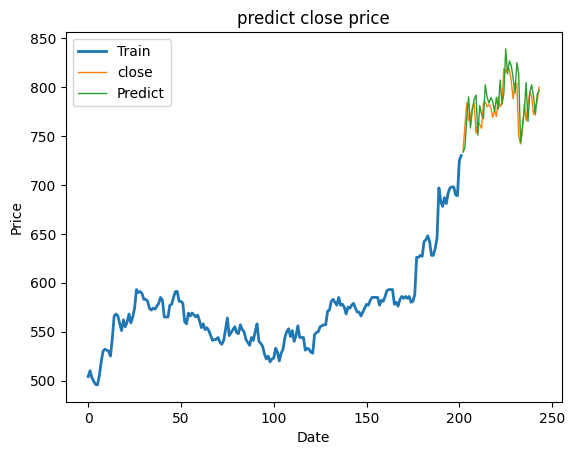

In [5]:
import matplotlib.pyplot as plt

preds=scaler.inverse_transform(reload_model.predict(test_x))

train_data=test_day[:train_ds_size+MOVING_WIN_SIZE]
test_data=test_day[train_ds_size+MOVING_WIN_SIZE:]
test_data=test_data.assign(Predict=preds)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title('predict close price')
plt.plot(train_data['clo'],linewidth=2)
plt.plot(test_data['clo'],linewidth=1)
plt.plot(test_data['Predict'],linewidth=1)

plt.legend(["Train","close","Predict"])
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error

test_data=test_data.assign(Shifted=test_data['clo'].shift(1))
test_data.iat[0,-1]=train_data.iat[-1,-1]

predict_rmse=mean_squared_error(test_data['clo'],test_data['Predict'],squared=False)
predict_cvrmse=predict_rmse / test_data['clo'].mean()*100

shifted_rmse=mean_squared_error(test_data['clo'],test_data['Shifted'],squared=False)
shifted_cvrmse=shifted_rmse / test_data['clo'].mean()*100


print(f"predict\t=  {predict_cvrmse} % \nshift\t=  {shifted_cvrmse} %")

predict	=  2.446230620169028 % 
shift	=  2.1276107527822123 %


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
